In [1]:
import sys
sys.path.append("..")
import pandas as pd
import os
from pathlib import Path
from glob import glob
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rasterio as rio
from src.feature_engineering import _enginner_features, aggregation

In [ ]:
# Finding subdirectories and loading needed files
shp_dirs = os.listdir("././Gijon2/aois/subasset_location_shp")
shp_dirs_selected = [d for d in shp_dirs if d != "Gijon_Perimeter"]
sen2_dirs = os.listdir("./Gijon2/Sentinel2")
sen2_dirs_selected = [d for d in sen2_dirs if d not in
                      ["L1C", "L2A", "Cloud_Images"]\
                      and d != "Cloud_report_Gijon.csv"]
nhi_swir_files = glob("./Gijon2/Sentinel2/NHI_SWIR/*.tif")
raw_cloud_files = glob("./Gijon2/Sentinel2/Cloud_Images/*.tif")

In [ ]:
# Extract feature from cloud-free files for all sentinel 2 indexes. Saving the output to new directory

for loc in shp_dirs_selected:
    for feature in sen2_dirs_selected:
        df = _enginner_features(
            folder_path=f"./Cropped_Images/CloudFree_Features2/{loc}/{feature}"
        )
        df.to_csv(
            f"./Engineered_Features/Time_series/{feature}_{loc}.csv"
        )

In [ ]:
# Iterating over all files to aggregate daily time series to monthly dates. Saving aggregated data to new directory.
csv_files = glob("./Engineered_Features/Time_series/*.csv")

for f in csv_files:
    original = f.split("/")[-1].split(".")[0]
    print(f"Original file name is {original}")
    loc = f.split("/")[3].split("_")[1]
    feat = f.split("/")[3].split("_")[0]
    df = pd.read_csv(f"{f}", index_col="Unnamed: 0")
    df = aggregation(df)

    processed = original + "_" + "Aggregated"
    print(f"processed file name is {processed}")
    df.to_csv(f"./Engineered_Features/Time_series_aggregated/{processed}.csv")

In [ ]:
# Reading observed iron production values and all aggregated files.

y = pd.read_csv("./Gijon2/PigIronProduction/Pig_Iron_Production_Spain.csv.csv")
agg_files = glob("./Engineered_Features/Time_series_aggregated/*.csv")

In [ ]:
# Converting all CSV files to pandas dataframe and storing them to a list.
df_list = []
for f in agg_files:
    df = pd.read_csv(f, index_col="Unnamed: 0")
    df_list.append(df)

In [ ]:
# Merging all dataframe in the lis and renaming columns.
df_full = reduce(lambda left, right: pd.merge(left, right, how="inner",
                                              on=["Year_", "Month_"]), df_list)
df_full.rename(columns={"Year_": "Year", "Month_": "Month"}, inplace=True)

In [ ]:
# Extracting year and month from date in the observed dataframe.
y["Date"] = pd.to_datetime(y["Date"])
y['Year'] = y["Date"].dt.year
y['Month'] = y["Date"].dt.month

In [ ]:
# Merging final aggregated dataframe and observed iron production data.
df_merge = pd.merge(df_full, y, how="inner",
             on=["Year", "Month"])

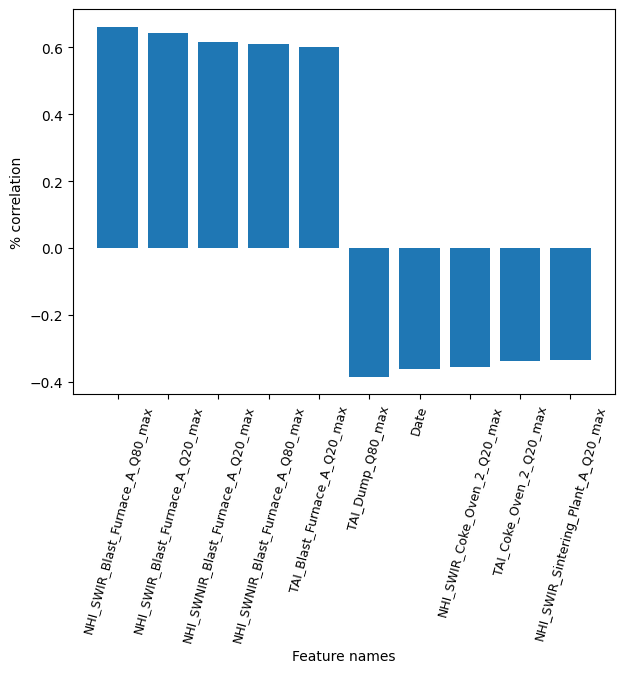

In [ ]:
# Finding the highes correlation between the target and monthly time series of all locations in the main training dataset.
# Combining highest 5 positive and negative features.
# Plotting the correlation between target and top 10 features. 
corr_matrix = df_merge.corr()
corr_cols = [col for col in corr_matrix.columns if col!="Value"]
positive_corr = corr_matrix.loc["Value", corr_cols].sort_values(ascending=False).head(5)
negative_corr = corr_matrix.loc["Value", corr_cols].sort_values(ascending=True).head(5)
best_corr = pd.DataFrame(pd.concat([positive_corr, negative_corr]))
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(best_corr.index, best_corr.Value.values)
ax.set_xlabel("Feature names")
ax.set_ylabel("% correlation")
ax.tick_params(axis="x", rotation=75, labelsize=9)
plt.show()

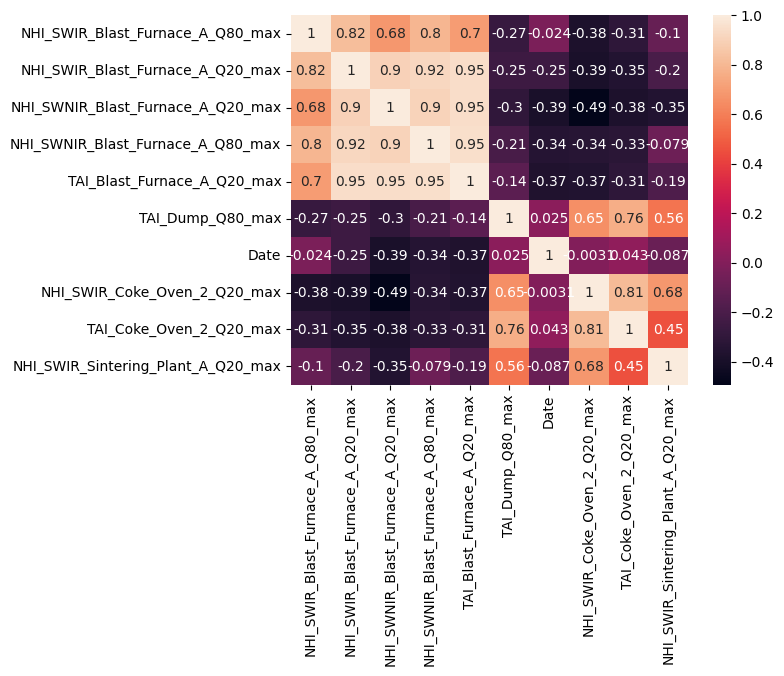

In [ ]:
# Discovering the presence of multicollinearity between top 10 features.
sns.heatmap(df_merge[best_corr.index].corr(), annot=True)
plt.show()

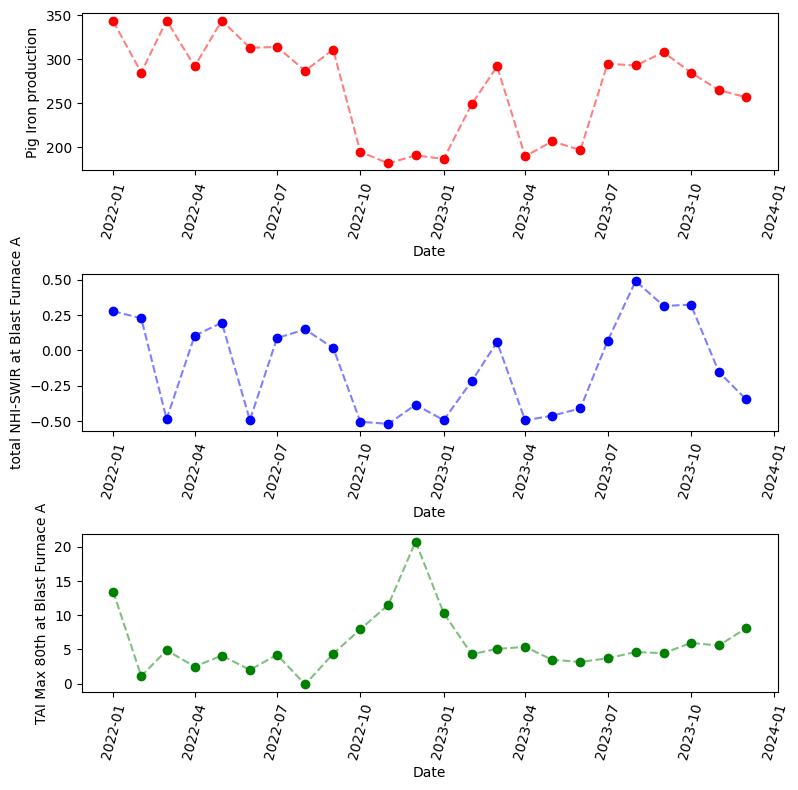

In [ ]:
# Picking the highest feature which is NH SWIR at Blast Furnace A.
# it has been found that all highest factors are all coming from NH SWIR at this location 
# therefore, the highest on will be pciked.
# Plotting the highest positive and negative features with the target variable.
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
d = df_merge.copy()
d["Date"] = pd.to_datetime(dict(year=d['Year'], month=d["Month"], day=1))
ax[0].scatter(d["Date"], d["Value"], c="r")
ax[0].plot(d["Date"], d["Value"], c="r", linestyle="dashed", alpha=0.5)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Pig Iron production")
ax[0].tick_params(rotation=75, axis="x")
ax[1].scatter(d["Date"], d["NHI_SWIR_Blast_Furnace_A_Q80_max"], c="b")
ax[1].plot(d["Date"], d["NHI_SWIR_Blast_Furnace_A_Q80_max"],
           c="b", linestyle="dashed", alpha=0.5)
ax[1].set_xlabel("Date")
ax[1].set_ylabel("total NHI-SWIR at Blast Furnace A")
ax[1].tick_params(rotation=75, axis="x")
ax[2].scatter(d["Date"], d["TAI_Dump_Q80_max"], c="g")
ax[2].plot(d["Date"], d["TAI_Dump_Q80_max"],
           c="g", linestyle="dashed", alpha=0.5)
ax[2].set_xlabel("Date")
ax[2].set_ylabel("TAI Max 80th at Blast Furnace A")
ax[2].tick_params(rotation=75, axis="x")
plt.tight_layout()
plt.show()

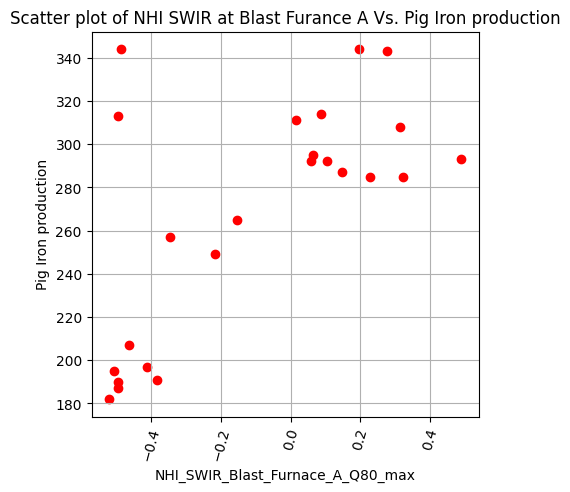

In [ ]:
# Scatter plot of the NHI SWIR and observed iron production. 
fig, ax = plt.subplots(figsize=(5,5))
d["Date"] = pd.to_datetime(dict(year=d['Year'], month=d["Month"], day=1))
ax.scatter(d["NHI_SWIR_Blast_Furnace_A_Q80_max"], d["Value"], c="r")
ax.set_xlabel("NHI_SWIR_Blast_Furnace_A_Q80_max")
ax.grid()
ax.set_ylabel("Pig Iron production")
ax.tick_params(rotation=75, axis="x")
ax.set_title("Scatter plot of NHI SWIR at Blast Furance A Vs. Pig Iron production")
plt.show()